In [1]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#load mnist data

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
base_url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
x_train = fetch(base_url + "train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
y_train = fetch(base_url + "train-labels-idx1-ubyte.gz")[8:]
x_test = fetch(base_url + "t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
y_test = fetch(base_url + "t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
# Layers Initialization

def layer_init(m, h):
    # Parameters:
    # m: number of input features
    # h: number of output features (neurons in the layer)

    # Gaussian initialization (commented out)
    # ret = np.random.randn(m, h)/np.sqrt(m*h)
    # This would initialize weights using a normal distribution (mean 0, std 1),
    # then scale by 1/sqrt(m*h) for Xavier/Glorot initialization

    # Uniform initialization
    # Uniform distribution is chosen as it's noted to be "stronger"
    ret = np.random.uniform(-1., 1., size=(m, h))/np.sqrt(m*h)
    # This initializes weights uniformly between -1 and 1,
    # then scales by 1/sqrt(m*h) for Xavier/Glorot initialization
    
    # The scaling factor 1/sqrt(m*h) helps maintain the variance of 
    # activations and gradients across layers, which can help with 
    # training in deep networks

    # Convert to 32-bit float for better performance and memory efficiency
    return ret.astype(np.float32)

# Set a fixed random seed for reproducibility
np.random.seed(1337)

# Initialize the weights for two layers
# l1: Input layer to hidden layer (784 inputs, 128 hidden neurons)
l1 = layer_init(784, 128)
# l2: Hidden layer to output layer (128 inputs, 10 output neurons for 10 digits)
l2 = layer_init(128, 10)

# Set the learning rate
lr = 0.001

# Set the batch size
BS = 128

# Note: The following improvements could be made:
# 1. Consider using a larger batch size (e.g., 256 or 512) for potentially faster convergence
# 2. Implement a learning rate schedule to decrease lr over time
# 3. Add momentum or use an optimizer like Adam for potentially better performance


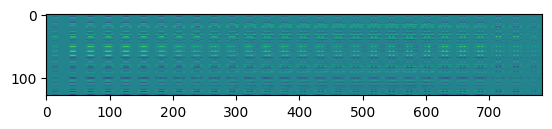

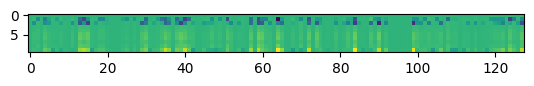

In [4]:
# Numpy Forward and Backward Pass

def logsumexp(x):
    # Naive implementation (commented out due to potential numerical instability):
    # return np.log(np.sum(np.exp(x).sum(axis=-1))
    
    # Numerically stable implementation:
    # Reference: http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    
    # Find the maximum value along each row
    # This will be used to normalize the exponents, preventing overflow
    c = x.max(axis=1)
    
    # Compute log(sum(exp(x))) in a numerically stable way:
    # 1. Subtract the max value from each element (x - c)
    # 2. Compute exp of the difference
    # 3. Sum the exponentials
    # 4. Take the log of the sum
    # 5. Add back the max value
    return c + np.log(np.exp(x - c.reshape(-1, 1)).sum(axis=1))
    
    # This is equivalent to log(sum(exp(x))) but avoids numerical overflow
    # It uses the identity: log(sum(exp(x))) = c + log(sum(exp(x - c)))
    # where c is max(x)

def forward_backward(x, y):
    # This function performs both forward and backward passes for training

    # Create a one-hot encoded matrix for the target labels
    out = np.zeros((len(y), 10), np.float32)
    # out.shape[0] is the number of samples
    # 10 is the number of classes (digits 0-9 for MNIST)

    # Set the correct class to 1 for each sample
    out[range(out.shape[0]), y] = 1
    # This creates a one-hot encoding where:
    # - range(out.shape[0]) gives indices for each sample
    # - y contains the correct label for each sample
    # - This operation sets the corresponding position to 1
    # For example, if y[0] = 3, then out[0, 3] = 1

    # Forward pass
    # x is the input data (batch of images)

    # First layer: Fully connected
    x_l1 = x.dot(l1)
    # x_l1 shape: (batch_size, 128)
    # This applies the first layer weights to the input

    # ReLU activation function
    x_relu = np.maximum(x_l1, 0)
    # x_relu shape: (batch_size, 128)
    # This applies the ReLU activation, max(0,x), element-wise

    # Second layer: Fully connected
    x_l2 = x_relu.dot(l2)
    # x_l2 shape: (batch_size, 10)
    # This applies the second layer weights to the ReLU output

    # Log softmax
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    # x_lsm shape: (batch_size, 10)
    # This computes the log softmax:
    # 1. logsumexp(x_l2) calculates log(sum(exp(x))) for each sample
    # 2. Reshape to (batch_size, 1) for broadcasting
    # 3. Subtract from x_l2 to get log softmax

    # Negative log likelihood loss
    x_loss = (-out * x_lsm).mean(axis=1)
    # x_loss shape: (batch_size,)
    # This computes the loss for each sample:
    # 1. Multiply the one-hot encoded labels (out) with log softmax outputs
    # 2. Sum across classes (implicit in the multiplication)
    # 3. Take the negative (because we want to minimize negative log likelihood)
    # 4. Average across the features/classes (axis=1)

    # Note: The final loss value is not computed here. Typically, you'd take
    # the mean of x_loss to get a single scalar loss for the batch
    
    # Backward pass
    # This section computes gradients for backpropagation

    # Compute initial gradient for output layer
    # d_out is the gradient of the loss with respect to the output
    # Divide by len(y) to normalize the gradient
    d_out = -out / len(y)

    # Compute gradient of log softmax
    # This is based on the derivative of log softmax function
    d_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))
    # d_lsm shape: (batch_size, 10)

    # Compute gradients for the second layer (l2)
    d_l2 = x_relu.T.dot(d_lsm)
    # d_l2 shape: (128, 10) - gradient for l2 weights
    dx_relu = d_lsm.dot(l2.T)
    # dx_relu shape: (batch_size, 128) - gradient flowing back to ReLU

    # Compute gradient through ReLU activation
    # ReLU derivative is 1 for positive inputs, 0 for negative
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
    # dx_l1 shape: (batch_size, 128)

    # Compute gradients for the first layer (l1)
    d_l1 = x.T.dot(dx_l1)
    # d_l1 shape: (784, 128) - gradient for l1 weights

    # Return computed loss, output of second layer, and gradients for both layers
    return x_loss, x_l2, d_l1, d_l2

    # Test the forward_backward function with a small sample
samp = [0,1,2,3]  # Select first 4 samples from test set
x_loss, x_l2, d_l1, d_l2 = forward_backward(x_test[samp].reshape(-1, 28*28), y_test[samp])
    # x_loss: loss for each sample
    # x_l2: output of second layer
    # d_l1, d_l2: gradients for first and second layer weights

plt.imshow(d_l1.T)
plt.figure()
plt.imshow(d_l2.T)

loss 0.04 accuracy 0.83: 100%|██████████| 1000/1000 [00:02<00:00, 351.92it/s]


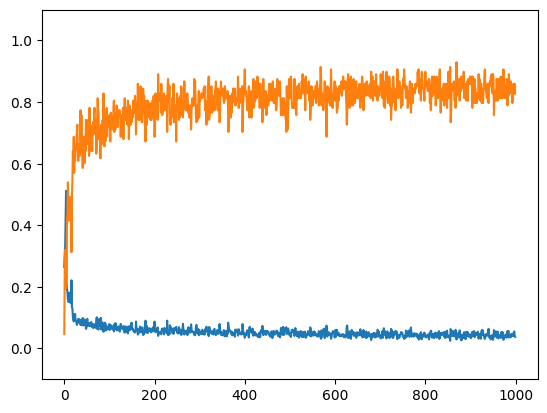

In [5]:
# Training loop
# Initialize lists to store losses and accuracies for each iteration
losses, accuracies = [], []

# Loop for 1000 iterations, using trange for a progress bar
for i in (t := trange(1000)):
    # Randomly sample a batch of data
    samp = np.random.randint(0, x_train.shape[0], size=(BS))
    # Reshape the sampled data to (batch_size, 784)
    X = x_train[samp].reshape((-1, 28*28))
    # Get the corresponding labels
    Y = y_train[samp]
    
    # Perform forward and backward pass
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
    # x_loss: loss for each sample in the batch
    # x_l2: output of the second layer
    # d_l1, d_l2: gradients for the first and second layer weights
    
    # Compute predictions and accuracy for this batch
    cat = np.argmax(x_l2, axis=1)  # Get predicted classes
    accuracy = (cat == Y).mean()   # Calculate accuracy
    
    # Stochastic Gradient Descent (SGD) update
    l1 = l1 - lr * d_l1  # Update first layer weights
    l2 = l2 - lr * d_l2  # Update second layer weights
    
    # Compute average loss for this batch
    loss = x_loss.mean()
    
    # Store loss and accuracy for later plotting
    losses.append(loss)
    accuracies.append(accuracy)
    
    # Update the progress bar description
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [6]:
# numpy eval
def forward(x):
    # First layer: Fully connected
    x = x.dot(l1)
    # x shape: (batch_size, 128)
    # This applies the first layer weights to the input

    # ReLU activation function
    x = np.maximum(x, 0)
    # x shape: (batch_size, 128)
    # This applies the ReLU activation, max(0,x), element-wise

    # Second layer: Fully connected
    x = x.dot(l2)
    # x shape: (batch_size, 10)
    # This applies the second layer weights to the ReLU output
    
    return x

def numpy_eval():
    # Reshape the test data to (num_samples, 784)
    Y_test_preds_out = forward(x_test.reshape((-1, 28*28)))
    # Y_test_preds_out shape: (num_test_samples, 10)
    
    # Get the predicted class (digit) for each sample
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    # Y_test_preds shape: (num_test_samples,)
    
    # Compare predictions with true labels and calculate accuracy
    return (y_test == Y_test_preds).mean().astype(np.float32)
    # This returns the fraction of correct predictions

numpy_eval()

np.float32(0.816)

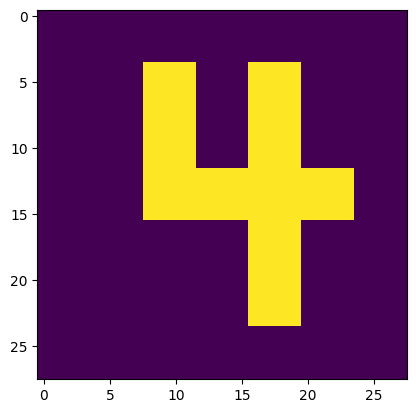

In [7]:
# for fun, can it recognize 4?
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28,28))